# Credit Card Fraud Detection - Model Development

Comparing different classifiers for fraud detection on an imbalanced dataset. We'll evaluate:
- Logistic Regression (baseline)
- LightGBM, XGBoost, CatBoost (gradient boosting)
- Isolation Forest (anomaly detection)

Primary metric: **AUPRC** (better suited for imbalanced data than ROC-AUC)

In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

from dotenv import load_dotenv
import dagshub

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [25]:
repo_owner = os.getenv('DAGSHUB_USERNAME')
repo_name = os.getenv('DAGSHUB_REPO_NAME')

dagshub.init(repo_owner=repo_owner, repo_name=repo_name, mlflow=True)

mlflow.set_experiment("Fraud_Detection_Benchmark")
mlflow.autolog(disable=True)  # We'll log manually for control

print(f"MLflow tracking: {mlflow.get_tracking_uri()}")

Accessing as mahaprasad003

Initialized MLflow to track repo "mahaprasad003/E2E-Fraud-Detection"

Repository mahaprasad003/E2E-Fraud-Detection initialized!

2026/01/05 17:44:32 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Benchmark' does not exist. Creating a new experiment.


MLflow tracking: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow


In [26]:
# Load dataset
DATA_PATH = "../data/raw/creditcard.csv"
df = pd.read_csv(DATA_PATH)

# Drop time column (not useful for modeling)
if 'Time' in df.columns:
    df = df.drop(columns=['Time'])

X = df.drop(columns=['Class'])
y = df['Class']

print(f"Dataset: {df.shape[0]:,} samples, {df.shape[1]} features")
print(f"Fraud rate: {y.mean():.4%} ({y.sum():,} cases)")

Dataset: 284,807 samples, 30 features
Fraud rate: 0.1727% (492 cases)


In [27]:
# Train/val/test split (64/16/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# Scale Amount column
scaler = RobustScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_val['Amount'] = scaler.transform(X_val[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

# For final training later
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Class weight for imbalanced learning
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")
print(f"Imbalance ratio: 1:{int(scale_pos_weight)}")

Train: 182,276 | Val: 45,569 | Test: 56,962
Imbalance ratio: 1:577


## Baseline: Logistic Regression

In [28]:
with mlflow.start_run(run_name="Baseline_LogReg"):
    lr_model = LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1
    )
    lr_model.fit(X_train, y_train)

    y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    auprc_lr = average_precision_score(y_test, y_proba_lr)
    roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

    mlflow.log_metric("test_auprc", auprc_lr)
    mlflow.log_metric("test_roc_auc", roc_auc_lr)
    
    print(f"Logistic Regression - AUPRC: {auprc_lr:.4f}, ROC-AUC: {roc_auc_lr:.4f}")

Logistic Regression - AUPRC: 0.7108, ROC-AUC: 0.9729
🏃 View run Baseline_LogReg at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b56a1aa36ad4459eac9581de17e72176
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


## LightGBM with Optuna

In [30]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    with mlflow.start_run(nested=True, run_name=f"LGB_Trial_{trial.number}"):
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='average_precision',
            callbacks=[early_stopping(stopping_rounds=30, verbose=False)]
        )
        y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
        score = average_precision_score(y_val, y_proba)
        
        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)
    
    return score

study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=30, timeout=300, show_progress_bar=True)

print(f"Best LightGBM AUPRC: {study_lgb.best_value:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run LGB_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/1241f0ac2a084867b30045ec50aa7590
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.0250404:   3%|▎         | 1/30 [00:03<01:51,  3.85s/it, 3.85/300 seconds]

🏃 View run LGB_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/fc47e79820ac4a1681c22761f6e79890
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.72525:   7%|▋         | 2/30 [00:07<01:37,  3.47s/it, 7.06/300 seconds]  

🏃 View run LGB_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/a7a367930b4744d2b6c850b9073d84c8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.72525:  10%|█         | 3/30 [00:09<01:19,  2.96s/it, 9.40/300 seconds]

🏃 View run LGB_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e108de6e846a4096822b9505ef608b5d
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.72525:  13%|█▎        | 4/30 [00:11<01:12,  2.81s/it, 11.97/300 seconds]

🏃 View run LGB_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/5778e009dba04491a3fff1990ef6fe57
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.72525:  17%|█▋        | 5/30 [00:15<01:17,  3.09s/it, 15.57/300 seconds]

🏃 View run LGB_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0e455c1b9d44444fa80f66a904450b77
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  20%|██        | 6/30 [00:23<01:56,  4.87s/it, 23.90/300 seconds]

🏃 View run LGB_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/bc79402e107e4669820c334ff5b6236e
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  23%|██▎       | 7/30 [00:26<01:32,  4.04s/it, 26.23/300 seconds]

🏃 View run LGB_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/5939edb41f0f4add9a9d5896703de511
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  27%|██▋       | 8/30 [00:30<01:30,  4.13s/it, 30.54/300 seconds]

🏃 View run LGB_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/cc0e096715e34003a6dedf8c484de77b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  30%|███       | 9/30 [00:35<01:32,  4.40s/it, 35.54/300 seconds]

🏃 View run LGB_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/373da61b8e81446a870f747e4e949b44
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  33%|███▎      | 10/30 [00:43<01:46,  5.35s/it, 43.02/300 seconds]

🏃 View run LGB_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8e3d15b21a6f4df79bdee9b0046b9f67
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  37%|███▋      | 11/30 [00:45<01:26,  4.53s/it, 45.70/300 seconds]

🏃 View run LGB_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/39b5ccf937304e1583f57d5961c7cc7b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  40%|████      | 12/30 [00:50<01:23,  4.65s/it, 50.62/300 seconds]

🏃 View run LGB_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/31a13e084ede4c77ad714c5d32dce10a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  43%|████▎     | 13/30 [00:55<01:20,  4.74s/it, 55.56/300 seconds]

🏃 View run LGB_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f9f0405e059344ae9c8016d4add8cdeb
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  47%|████▋     | 14/30 [01:00<01:17,  4.82s/it, 60.56/300 seconds]

🏃 View run LGB_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/d5451d3dbb73486fa2fbc0d777d92089
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  50%|█████     | 15/30 [01:05<01:13,  4.87s/it, 65.56/300 seconds]

🏃 View run LGB_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/585c8288ca044f278e42bd3fa18d4a92
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  53%|█████▎    | 16/30 [01:10<01:08,  4.92s/it, 70.58/300 seconds]

🏃 View run LGB_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/78c50fc340dd4989a180ba80487bd56f
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  57%|█████▋    | 17/30 [01:15<01:04,  4.93s/it, 75.55/300 seconds]

🏃 View run LGB_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9502303008b547568ddfaa78e87fa1ee
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  60%|██████    | 18/30 [01:20<00:59,  4.94s/it, 80.51/300 seconds]

🏃 View run LGB_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0b44f77c517849858b06250cd8c5619b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  63%|██████▎   | 19/30 [01:25<00:54,  4.98s/it, 85.57/300 seconds]

🏃 View run LGB_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/713e38ed0b9e482faf2d05a8d64e1fb2
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  67%|██████▋   | 20/30 [01:30<00:50,  5.02s/it, 90.70/300 seconds]

🏃 View run LGB_Trial_20 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9328f9b936134527bbb8998723fbc687
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  70%|███████   | 21/30 [01:35<00:44,  4.98s/it, 95.58/300 seconds]

🏃 View run LGB_Trial_21 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/6318a605db61432799a0511c7757e856
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  73%|███████▎  | 22/30 [01:43<00:47,  5.93s/it, 103.72/300 seconds]

🏃 View run LGB_Trial_22 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8bdec9ae5c1b4b7b862e0ac129167585
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  77%|███████▋  | 23/30 [01:46<00:34,  4.88s/it, 106.15/300 seconds]

🏃 View run LGB_Trial_23 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/7624c960a9f54206a6bae633e0026573
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  80%|████████  | 24/30 [01:50<00:28,  4.80s/it, 110.77/300 seconds]

🏃 View run LGB_Trial_24 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/a23503e7597b4ee2a32a580ecd96d3df
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  83%|████████▎ | 25/30 [01:55<00:24,  4.85s/it, 115.75/300 seconds]

🏃 View run LGB_Trial_25 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/27619bb5e8724c989bb696fad41ff534
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  87%|████████▋ | 26/30 [02:02<00:22,  5.55s/it, 122.93/300 seconds]

🏃 View run LGB_Trial_26 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/29f094b66bde475eb3ce1a3791d81c31
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  90%|█████████ | 27/30 [02:10<00:18,  6.14s/it, 130.44/300 seconds]

🏃 View run LGB_Trial_27 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/a427aeed5ce84daeae29f89270886b3c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  93%|█████████▎| 28/30 [02:12<00:09,  5.00s/it, 132.78/300 seconds]

🏃 View run LGB_Trial_28 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f216114323bc4de4806a43f76461c2d8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882:  97%|█████████▋| 29/30 [02:15<00:04,  4.34s/it, 135.57/300 seconds]

🏃 View run LGB_Trial_29 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/78f778b84e254320adc12d6bdbada277
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 5. Best value: 0.823882: 100%|██████████| 30/30 [02:20<00:00,  4.69s/it, 140.55/300 seconds]

Best LightGBM AUPRC: 0.8239


In [31]:
# Train final LightGBM with best params
with mlflow.start_run(run_name="Final_LightGBM"):
    final_params_lgb = study_lgb.best_params.copy()
    final_params_lgb.update({
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'n_estimators': 1000,
        'verbose': -1
    })

    final_model_lgb = LGBMClassifier(**final_params_lgb)
    final_model_lgb.fit(
        X_train_full, y_train_full,
        eval_set=[(X_test, y_test)],
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    y_proba_lgb = final_model_lgb.predict_proba(X_test, num_iteration=final_model_lgb.best_iteration_)[:, 1]
    auprc_lgb = average_precision_score(y_test, y_proba_lgb)
    roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

    mlflow.log_params(final_params_lgb)
    mlflow.log_metric("test_auprc", auprc_lgb)
    mlflow.log_metric("test_roc_auc", roc_auc_lgb)
    
    print(f"LightGBM - AUPRC: {auprc_lgb:.4f}, ROC-AUC: {roc_auc_lgb:.4f}")

LightGBM - AUPRC: 0.8645, ROC-AUC: 0.9626
🏃 View run Final_LightGBM at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/ea83c655cbc74b77a21a95b91a849e17
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


## XGBoost with Optuna

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr'
    }
    
    with mlflow.start_run(nested=True, run_name=f"XGB_Trial_{trial.number}"):
        model = XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_proba = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_proba)
        
        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)
    
    return score

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=30, timeout=600, show_progress_bar=True)

print(f"Best XGBoost AUPRC: {study_xgb.best_value:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run XGB_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/4545fee80c894a369fbceac3d014198d
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:   3%|▎         | 1/30 [00:05<02:46,  5.75s/it, 5.75/600 seconds]

🏃 View run XGB_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/653e9e140ad54ccabfc497f0ed2063af
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:   7%|▋         | 2/30 [00:16<04:00,  8.60s/it, 16.35/600 seconds]

🏃 View run XGB_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/773b7257150048c4be0492a7284c710a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:  10%|█         | 3/30 [00:23<03:38,  8.09s/it, 23.83/600 seconds]

🏃 View run XGB_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/c4ef0ac54472453ab2cfa5b468d41436
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:  13%|█▎        | 4/30 [00:29<03:01,  6.98s/it, 29.12/600 seconds]

🏃 View run XGB_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/c092d15627494aee9d3a4bdadf3ac279
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:  17%|█▋        | 5/30 [00:35<02:50,  6.82s/it, 35.65/600 seconds]

🏃 View run XGB_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9244fcc2401645aab3fe651c1a264116
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.836832:  20%|██        | 6/30 [00:44<02:57,  7.40s/it, 44.17/600 seconds]

🏃 View run XGB_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/6099ef02149e438c80eae485b0eb549b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  23%|██▎       | 7/30 [00:50<02:38,  6.89s/it, 50.02/600 seconds]

🏃 View run XGB_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/cd66754f141c4708976a5dccc2d7a37c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  27%|██▋       | 8/30 [00:56<02:29,  6.81s/it, 56.64/600 seconds]

🏃 View run XGB_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/7d6253bed3234f83ab700cbb06dd8c03
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  30%|███       | 9/30 [01:00<02:00,  5.73s/it, 60.01/600 seconds]

🏃 View run XGB_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/584cdaaaa7e44c61bb53e853abda4beb
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  33%|███▎      | 10/30 [01:06<01:58,  5.92s/it, 66.35/600 seconds]

🏃 View run XGB_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8625aadba53d4905921553c5815580a3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  37%|███▋      | 11/30 [01:13<02:01,  6.41s/it, 73.88/600 seconds]

🏃 View run XGB_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f4bc4fd5d7194a16a0b2b72fc62c2848
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  40%|████      | 12/30 [01:19<01:51,  6.19s/it, 79.58/600 seconds]

🏃 View run XGB_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/723ce9edbb73454a82517d34b7471c83
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 6. Best value: 0.839475:  43%|████▎     | 13/30 [01:51<03:59, 14.11s/it, 111.88/600 seconds]

🏃 View run XGB_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/d98c412204574bf4a7f7e0f8ec313e0d
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  47%|████▋     | 14/30 [02:04<03:36, 13.56s/it, 124.19/600 seconds]

🏃 View run XGB_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/01cb2ca76ad24a6eb9450162fd58e94d
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  50%|█████     | 15/30 [02:09<02:44, 10.98s/it, 129.19/600 seconds]

🏃 View run XGB_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/2f90c16cd79e4293bb3016bbd1f222fe
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  53%|█████▎    | 16/30 [02:20<02:34, 11.07s/it, 140.45/600 seconds]

🏃 View run XGB_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f56d20f7081a48da8ec3c1ba59e289b5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  57%|█████▋    | 17/30 [02:28<02:13, 10.27s/it, 148.87/600 seconds]

🏃 View run XGB_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/1d5e4497f33e4c44ac5799430bc53571
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  60%|██████    | 18/30 [02:33<01:43,  8.62s/it, 153.65/600 seconds]

🏃 View run XGB_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/44bc19e0efcb49ceb4da7d3f042c18f7
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  63%|██████▎   | 19/30 [02:37<01:19,  7.21s/it, 157.58/600 seconds]

🏃 View run XGB_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/3184309c8da945e9b52d30216d8117a2
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  67%|██████▋   | 20/30 [02:43<01:07,  6.74s/it, 163.21/600 seconds]

🏃 View run XGB_Trial_20 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/93f6231842a949739c60939126cd8e97
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 13. Best value: 0.84239:  70%|███████   | 21/30 [02:52<01:08,  7.57s/it, 172.73/600 seconds]

🏃 View run XGB_Trial_21 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/480c02f792234fa18c524a3921930143
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  73%|███████▎  | 22/30 [02:58<00:56,  7.09s/it, 178.69/600 seconds]

🏃 View run XGB_Trial_22 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/4a90ccc27c1c4dc2b06ce802fcedc742
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  77%|███████▋  | 23/30 [03:03<00:45,  6.54s/it, 183.96/600 seconds]

🏃 View run XGB_Trial_23 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/06b7e9d4ece74fa0a771d438a6fa27f9
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  80%|████████  | 24/30 [03:08<00:34,  5.80s/it, 188.01/600 seconds]

🏃 View run XGB_Trial_24 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e96759668806423eae706bef3becc69f
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  83%|████████▎ | 25/30 [03:14<00:30,  6.08s/it, 194.75/600 seconds]

🏃 View run XGB_Trial_25 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9b8188991417423ba3742b2423194aca
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  87%|████████▋ | 26/30 [03:20<00:24,  6.11s/it, 200.94/600 seconds]

🏃 View run XGB_Trial_26 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8d190c2bd6e04efeb96070d864b55e05
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  90%|█████████ | 27/30 [03:27<00:18,  6.33s/it, 207.77/600 seconds]

🏃 View run XGB_Trial_27 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b4563e5cdbf54174869f269f82d8c353
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  93%|█████████▎| 28/30 [03:32<00:11,  5.85s/it, 212.51/600 seconds]

🏃 View run XGB_Trial_28 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0e6a6f97fc7f43afbf943f81e662de89
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209:  97%|█████████▋| 29/30 [03:38<00:05,  5.95s/it, 218.70/600 seconds]

🏃 View run XGB_Trial_29 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/a9d7f91b2f774d23a7a2e20c6f708335
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 21. Best value: 0.843209: 100%|██████████| 30/30 [03:44<00:00,  7.49s/it, 224.58/600 seconds]

Best XGBoost AUPRC: 0.8432


In [33]:
# Train final XGBoost
with mlflow.start_run(run_name="Final_XGBoost"):
    final_params_xgb = study_xgb.best_params.copy()
    final_params_xgb.update({
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist',
        'eval_metric': 'aucpr',
        'n_estimators': 1000
    })

    final_model_xgb = XGBClassifier(**final_params_xgb)
    final_model_xgb.fit(X_train_full, y_train_full, eval_set=[(X_test, y_test)], verbose=False)

    y_proba_xgb = final_model_xgb.predict_proba(X_test)[:, 1]
    auprc_xgb = average_precision_score(y_test, y_proba_xgb)
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

    mlflow.log_params(final_params_xgb)
    mlflow.log_metric("test_auprc", auprc_xgb)
    mlflow.log_metric("test_roc_auc", roc_auc_xgb)
    
    print(f"XGBoost - AUPRC: {auprc_xgb:.4f}, ROC-AUC: {roc_auc_xgb:.4f}")

XGBoost - AUPRC: 0.8716, ROC-AUC: 0.9787
🏃 View run Final_XGBoost at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/a142a71b89804a8baa1467234a69180b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


## CatBoost with Optuna

In [34]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'auto_class_weights': 'Balanced',
        'loss_function': 'Logloss',
        'eval_metric': 'PRAUC',
        'verbose': False,
        'random_seed': RANDOM_STATE,
        'task_type': 'CPU'
    }
    
    with mlflow.start_run(nested=True, run_name=f"Cat_Trial_{trial.number}"):
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
        y_proba = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_proba)
        
        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)
    
    return score

study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_cat, n_trials=30, timeout=600, show_progress_bar=True)

print(f"Best CatBoost AUPRC: {study_cat.best_value:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run Cat_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e6b211407d5f4fe7ad0af32e6790ca77
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.703309:   3%|▎         | 1/30 [00:07<03:37,  7.49s/it, 7.49/600 seconds]

🏃 View run Cat_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/77ff5e6b3a1b43929435e4a54f0f5b86
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:   7%|▋         | 2/30 [00:18<04:19,  9.28s/it, 18.03/600 seconds]

🏃 View run Cat_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8f707b4596c54b9bb3cdcc2bbce178c3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  10%|█         | 3/30 [00:22<03:14,  7.20s/it, 22.74/600 seconds]

🏃 View run Cat_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e5fdf756f53d40a8bbc1eb399ce0ebc2
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  13%|█▎        | 4/30 [00:30<03:11,  7.35s/it, 30.33/600 seconds]

🏃 View run Cat_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/de5e1db221624b78a35e3fb0aa4740d0
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  17%|█▋        | 5/30 [00:34<02:38,  6.33s/it, 34.85/600 seconds]

🏃 View run Cat_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0c853b06cbc84c6fbe5de691efa78fc4
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  20%|██        | 6/30 [00:41<02:38,  6.61s/it, 42.00/600 seconds]

🏃 View run Cat_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/bbf5a27d05b54151a9369e26c07da450
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  23%|██▎       | 7/30 [00:47<02:25,  6.31s/it, 47.70/600 seconds]

🏃 View run Cat_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8da8a142aa82414db29683c6b3a75429
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  27%|██▋       | 8/30 [00:52<02:04,  5.67s/it, 52.01/600 seconds]

🏃 View run Cat_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/95592c79052943668d8e5566a29b18fc
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  30%|███       | 9/30 [01:13<03:40, 10.48s/it, 73.07/600 seconds]

🏃 View run Cat_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9ade01d0ba344cac956f4de22e320f8f
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  33%|███▎      | 10/30 [01:17<02:50,  8.53s/it, 77.21/600 seconds]

🏃 View run Cat_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/4581f555b65f4d05b1fc34f3483c2d7e
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  37%|███▋      | 11/30 [01:22<02:24,  7.63s/it, 82.81/600 seconds]

🏃 View run Cat_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/10874515adbf439897ac4b3e1d968257
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  40%|████      | 12/30 [01:28<02:05,  6.95s/it, 88.21/600 seconds]

🏃 View run Cat_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/11646202c2864bc7a0158702c185770e
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  43%|████▎     | 13/30 [01:37<02:12,  7.79s/it, 97.94/600 seconds]

🏃 View run Cat_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/3e11f15f466848d2bf0eea4173015d2c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  47%|████▋     | 14/30 [01:45<02:01,  7.62s/it, 105.15/600 seconds]

🏃 View run Cat_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/3b4749e8e8f1425f965381e04ab4bde6
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  50%|█████     | 15/30 [01:50<01:45,  7.00s/it, 110.72/600 seconds]

🏃 View run Cat_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f46bd447381f48efab4b0f1bca436268
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  53%|█████▎    | 16/30 [01:55<01:29,  6.39s/it, 115.71/600 seconds]

🏃 View run Cat_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f04a0d08dc23407792ab00e56ead42c2
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.800538:  57%|█████▋    | 17/30 [02:12<02:02,  9.44s/it, 132.23/600 seconds]

🏃 View run Cat_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/bf72fad089634240816ad1fe3476aea8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  60%|██████    | 18/30 [02:28<02:19, 11.61s/it, 148.89/600 seconds]

🏃 View run Cat_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e41859df656f49c5aafdb0e5b7e527d5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  63%|██████▎   | 19/30 [02:40<02:06, 11.51s/it, 160.15/600 seconds]

🏃 View run Cat_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/596b37546f7247e290896e11dae31276
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  67%|██████▋   | 20/30 [02:51<01:55, 11.57s/it, 171.88/600 seconds]

🏃 View run Cat_Trial_20 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/fe913ac31e014ecba3236f9eca8499c2
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  70%|███████   | 21/30 [03:09<02:00, 13.39s/it, 189.49/600 seconds]

🏃 View run Cat_Trial_21 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b20fedc3989e452f9b8618ddde6a57ff
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  73%|███████▎  | 22/30 [03:20<01:41, 12.63s/it, 200.35/600 seconds]

🏃 View run Cat_Trial_22 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/4e743552443443e8bc535fd020a16355
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  77%|███████▋  | 23/30 [03:29<01:21, 11.70s/it, 209.90/600 seconds]

🏃 View run Cat_Trial_23 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/9fb613b2b8d94c56b40a32ac1f829a68
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  80%|████████  | 24/30 [03:38<01:03, 10.65s/it, 218.08/600 seconds]

🏃 View run Cat_Trial_24 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/2f912b6cd1f341429893d2b5924942a8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  83%|████████▎ | 25/30 [03:43<00:45,  9.12s/it, 223.63/600 seconds]

🏃 View run Cat_Trial_25 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0bce3a47d5f149c99c015258ade11736
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  87%|████████▋ | 26/30 [03:54<00:38,  9.58s/it, 234.29/600 seconds]

🏃 View run Cat_Trial_26 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0e86ae8868314e2bb3c7dfc2a7348202
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  90%|█████████ | 27/30 [03:59<00:25,  8.34s/it, 239.75/600 seconds]

🏃 View run Cat_Trial_27 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/8ce65438e0264f8ba97b21555a4ae51a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  93%|█████████▎| 28/30 [04:07<00:16,  8.02s/it, 247.00/600 seconds]

🏃 View run Cat_Trial_28 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/24dfe3c60fda40dbad4f7dd33047103c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326:  97%|█████████▋| 29/30 [04:12<00:07,  7.34s/it, 252.75/600 seconds]

🏃 View run Cat_Trial_29 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/461513faf6564d639d16d8fbf9787354
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 17. Best value: 0.816326: 100%|██████████| 30/30 [04:26<00:00,  8.88s/it, 266.43/600 seconds]

Best CatBoost AUPRC: 0.8163


In [35]:
# Train final CatBoost
with mlflow.start_run(run_name="Final_CatBoost"):
    final_params_cat = study_cat.best_params.copy()
    final_params_cat.update({
        'auto_class_weights': 'Balanced',
        'bootstrap_type': 'Bernoulli',
        'eval_metric': 'PRAUC',
        'random_seed': RANDOM_STATE,
        'iterations': 2000,
        'verbose': False
    })

    final_model_cat = CatBoostClassifier(**final_params_cat)
    final_model_cat.fit(
        X_train_full, y_train_full,
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        verbose=False
    )

    y_proba_cat = final_model_cat.predict_proba(X_test)[:, 1]
    auprc_cat = average_precision_score(y_test, y_proba_cat)
    roc_auc_cat = roc_auc_score(y_test, y_proba_cat)

    mlflow.log_params(final_params_cat)
    mlflow.log_metric("test_auprc", auprc_cat)
    mlflow.log_metric("test_roc_auc", roc_auc_cat)
    mlflow.catboost.log_model(final_model_cat, "model")
    
    print(f"CatBoost - AUPRC: {auprc_cat:.4f}, ROC-AUC: {roc_auc_cat:.4f}")

2026/01/05 18:04:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 18:05:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


CatBoost - AUPRC: 0.8055, ROC-AUC: 0.9748
🏃 View run Final_CatBoost at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/333fcc9f58d0405d901dcae598805349
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


## Isolation Forest (Unsupervised)

In [36]:
def objective_iso(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'contamination': 'auto',
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }
    
    with mlflow.start_run(nested=True, run_name=f"Iso_Trial_{trial.number}"):
        model = IsolationForest(**params)
        model.fit(X_train)
        scores = -model.decision_function(X_val)
        score = average_precision_score(y_val, scores)
        
        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)
    
    return score

study_iso = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_iso.optimize(objective_iso, n_trials=20, timeout=400, show_progress_bar=True)

print(f"Best Isolation Forest AUPRC: {study_iso.best_value:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

🏃 View run Iso_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/f042e0746c9440c79bab6178a280aa30
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 0. Best value: 0.174225:   5%|▌         | 1/20 [00:06<02:10,  6.85s/it, 6.85/400 seconds]

🏃 View run Iso_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/5192cd5cffea43faa6958b14aa4856b3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  10%|█         | 2/20 [00:11<01:40,  5.57s/it, 11.52/400 seconds]

🏃 View run Iso_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/bd5cba58f2ed42a888c1232a366a6a06
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  15%|█▌        | 3/20 [00:15<01:23,  4.94s/it, 15.71/400 seconds]

🏃 View run Iso_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/eaafd897713847bca1e06ecf8d31b6bc
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  20%|██        | 4/20 [00:20<01:16,  4.79s/it, 20.26/400 seconds]

🏃 View run Iso_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b9a461645f6e48c299924e78c1e1271c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  25%|██▌       | 5/20 [00:27<01:22,  5.50s/it, 27.02/400 seconds]

🏃 View run Iso_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/ddc94d36bfb54640ae4f2a932bc2b89b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  30%|███       | 6/20 [00:33<01:22,  5.87s/it, 33.61/400 seconds]

🏃 View run Iso_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/7c733cc184bf4bb3b57ebf41874189ed
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 1. Best value: 0.174951:  35%|███▌      | 7/20 [00:39<01:18,  6.02s/it, 39.95/400 seconds]

🏃 View run Iso_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/0a4e8df5d16543f7812f33c8f010d916
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 7. Best value: 0.176198:  40%|████      | 8/20 [00:46<01:14,  6.22s/it, 46.60/400 seconds]

🏃 View run Iso_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/10c4f56d4d0547cda02c68e81ce9a9ea
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 7. Best value: 0.176198:  45%|████▌     | 9/20 [00:50<01:01,  5.62s/it, 50.90/400 seconds]

🏃 View run Iso_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/1c68a184c836485f96221acabf6c80e1
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 7. Best value: 0.176198:  50%|█████     | 10/20 [00:57<00:59,  5.91s/it, 57.45/400 seconds]

🏃 View run Iso_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/90c5cc3395364c659e1d24b33f4b66e9
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 7. Best value: 0.176198:  55%|█████▌    | 11/20 [01:07<01:05,  7.30s/it, 67.90/400 seconds]

🏃 View run Iso_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/30bbc396615a4b098a209ae357519816
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 11. Best value: 0.177265:  60%|██████    | 12/20 [01:13<00:54,  6.76s/it, 73.43/400 seconds]

🏃 View run Iso_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b01e454f3284460aaa2ce6291d4681db
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 11. Best value: 0.177265:  65%|██████▌   | 13/20 [01:19<00:44,  6.40s/it, 79.01/400 seconds]

🏃 View run Iso_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/37ddae36e5e045d9bd6e8429a9605076
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 11. Best value: 0.177265:  70%|███████   | 14/20 [01:27<00:42,  7.01s/it, 87.43/400 seconds]

🏃 View run Iso_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/b7f651e213e547bebcb04713b101b10b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 14. Best value: 0.179712:  75%|███████▌  | 15/20 [01:33<00:32,  6.58s/it, 93.01/400 seconds]

🏃 View run Iso_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/62268b439b954ebf8a594bc7f72eb6eb
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 15. Best value: 0.182356:  80%|████████  | 16/20 [01:40<00:27,  6.76s/it, 100.20/400 seconds]

🏃 View run Iso_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e6c0d25b6701430d85eb79e848da6a4a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 15. Best value: 0.182356:  85%|████████▌ | 17/20 [01:47<00:20,  6.84s/it, 107.20/400 seconds]

🏃 View run Iso_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/99d42db272c646829167162e198e18c5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 15. Best value: 0.182356:  90%|█████████ | 18/20 [01:54<00:13,  6.83s/it, 114.01/400 seconds]

🏃 View run Iso_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/1502d9b78d194829a9dfe7fe5115e393
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 18. Best value: 0.182415:  95%|█████████▌| 19/20 [02:00<00:06,  6.72s/it, 120.49/400 seconds]

🏃 View run Iso_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/47de269c57084f269c4204c736fde58b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


Best trial: 18. Best value: 0.182415: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it, 126.45/400 seconds]

Best Isolation Forest AUPRC: 0.1824


Isolation forest was clearly just a bad idea.

In [37]:
# Train final Isolation Forest
with mlflow.start_run(run_name="Final_IsoForest"):
    final_params_iso = study_iso.best_params.copy()
    final_params_iso.update({'n_jobs': -1, 'random_state': RANDOM_STATE})

    final_model_iso = IsolationForest(**final_params_iso)
    final_model_iso.fit(X_train_full)

    y_scores_iso = -final_model_iso.decision_function(X_test)
    auprc_iso = average_precision_score(y_test, y_scores_iso)
    roc_auc_iso = roc_auc_score(y_test, y_scores_iso)

    mlflow.log_params(final_params_iso)
    mlflow.log_metric("test_auprc", auprc_iso)
    mlflow.log_metric("test_roc_auc", roc_auc_iso)
    mlflow.sklearn.log_model(final_model_iso, "model")
    
    print(f"Isolation Forest - AUPRC: {auprc_iso:.4f}, ROC-AUC: {roc_auc_iso:.4f}")

2026/01/05 18:08:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 18:08:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Isolation Forest - AUPRC: 0.2580, ROC-AUC: 0.9619
🏃 View run Final_IsoForest at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/d3cb27bb460944aa9035b95d35e05df3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4


## Results Comparison

In [39]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM', 'XGBoost', 'CatBoost', 'Isolation Forest'],
    'AUPRC': [auprc_lr, auprc_lgb, auprc_xgb, auprc_cat, auprc_iso],
    'ROC-AUC': [roc_auc_lr, roc_auc_lgb, roc_auc_xgb, roc_auc_cat, roc_auc_iso]
})

print(results.sort_values('AUPRC', ascending=False).to_string(index=False))

              Model    AUPRC  ROC-AUC
            XGBoost 0.871580 0.978715
           LightGBM 0.864515 0.962570
           CatBoost 0.805468 0.974824
Logistic Regression 0.710755 0.972866
   Isolation Forest 0.258040 0.961902


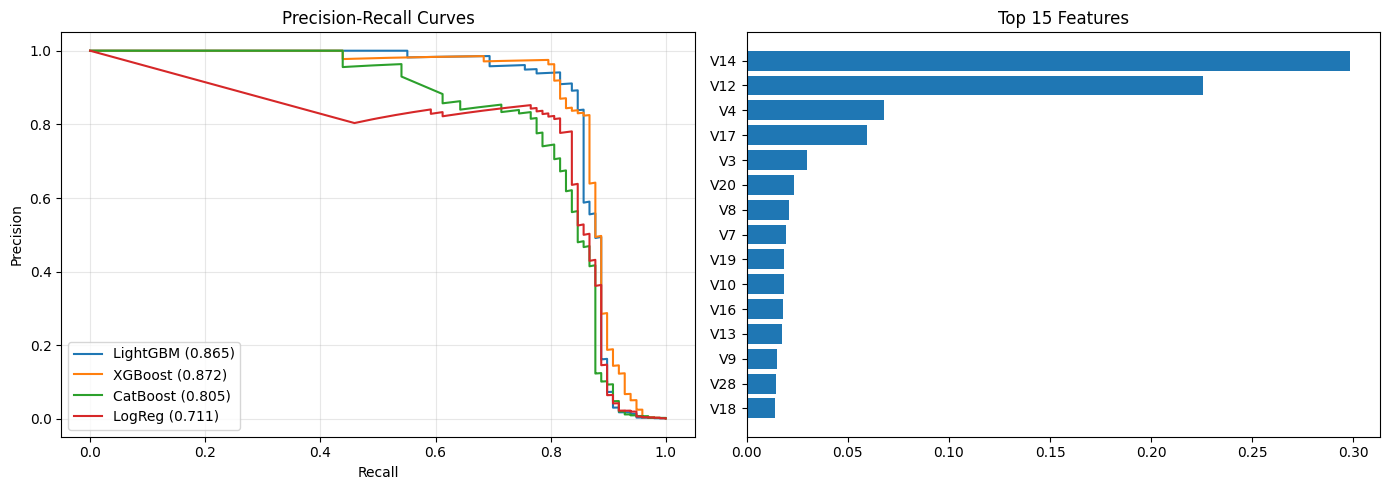

In [40]:
# PR curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR curves
for name, proba in [('LightGBM', y_proba_lgb), ('XGBoost', y_proba_xgb), 
                     ('CatBoost', y_proba_cat), ('LogReg', y_proba_lr)]:
    p, r, _ = precision_recall_curve(y_test, proba)
    auprc = average_precision_score(y_test, proba)
    axes[0].plot(r, p, label=f'{name} ({auprc:.3f})')

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Feature importance (best model)
best_model = final_model_xgb  # or whichever has best AUPRC
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).nlargest(15, 'importance')

axes[1].barh(range(len(importances)), importances['importance'])
axes[1].set_yticks(range(len(importances)))
axes[1].set_yticklabels(importances['feature'])
axes[1].set_title('Top 15 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=150)
plt.show()

## Cross-Validation (XGBoost)

In [18]:
import xgboost as xgb

# Prepare DMatrix for native XGBoost CV
dtrain = xgb.DMatrix(X_train_full, label=y_train_full)

# Convert sklearn params to native xgb.cv params
xgb_cv_params = final_params_xgb.copy()

# Remove sklearn-specific keys not recognized by native API
for key in ['n_estimators', 'n_jobs']:
    xgb_cv_params.pop(key, None)

# Add/update native XGBoost keys
xgb_cv_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'nthread': -1
})

cv_results = xgb.cv(
    params=xgb_cv_params,
    dtrain=dtrain,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    metrics='aucpr',
    early_stopping_rounds=50,
    seed=RANDOM_STATE,
    verbose_eval=50
)

best_iteration = len(cv_results)
best_cv_score = cv_results['test-aucpr-mean'].iloc[-1]
cv_std = cv_results['test-aucpr-std'].iloc[-1]

print(f"CV AUPRC: {best_cv_score:.4f} +/- {cv_std:.4f} (best iter: {best_iteration})")

[0]	train-aucpr:0.70391+0.02510	test-aucpr:0.56457+0.07944
[50]	train-aucpr:0.99510+0.00154	test-aucpr:0.84209+0.04812
[100]	train-aucpr:0.99969+0.00062	test-aucpr:0.84824+0.04582
[150]	train-aucpr:0.99998+0.00004	test-aucpr:0.85076+0.04169
[200]	train-aucpr:1.00000+0.00000	test-aucpr:0.84963+0.04443
CV AUPRC: 0.8508 +/- 0.0417 (best iter: 151)


## Export Production Model

Train on full dataset and save artifacts for deployment.

In [42]:
# Combine all data for final training
X_all = pd.concat([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test])

# Use optimal iteration from CV
production_params = final_params_xgb.copy()
production_params['n_estimators'] = best_iteration

with mlflow.start_run(run_name="Production_Model"):
    prod_model = XGBClassifier(**production_params)
    prod_model.fit(X_all, y_all)

    # Save artifacts locally
    joblib.dump(prod_model, '../models/production/xgb_model.joblib')
    joblib.dump(scaler, '../models/production/scaler.joblib')
    
    # Log to MLflow
    mlflow.log_artifact('../models/production/scaler.joblib')
    mlflow.log_params(production_params)
    mlflow.log_metric("cv_auprc", best_cv_score)
    
    print(f"Saved model ({best_iteration} trees) and scaler")
    print(f"Model registered as 'Fraud_Detector_XGB'")

Saved model (151 trees) and scaler
Model registered as 'Fraud_Detector_XGB'
🏃 View run Production_Model at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4/runs/e05d7b1cd11a46bf8261ec937b9b9d17
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/4
